<a href="https://colab.research.google.com/github/nxf-emma/APS360-Artificial-Intelligence-Fundamentals/blob/main/0_56_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# train

In [15]:
def get_accuracy(model, dataloader):
    

    correct = 0
    total = 0
    for imgs, labels in dataloader:
        
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
#Convolutional Neural Network Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 

        self.conv1 = nn.Conv2d(3, 5, 3, padding = 2) #in_channels, out_chanels, kernel_size 
        self.conv2 = nn.Conv2d(5, 25, 3) #in_channels, out_chanels, kernel_size
        self.conv3 = nn.Conv2d(25, 50, 1)
        self.conv4 = nn.Conv2d(50, 200, 1)
        
        self.fc1 = nn.Linear(200*2*2, 70) #chanels*dimension
        self.fc3 = nn.Linear(70, 32)
        self.fc2 = nn.Linear(32, 7) #last output channel always = 7
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # 25x25
        x = self.pool(F.relu(self.conv2(x)))
        # 11
        x = self.pool(F.relu(self.conv3(x)))
        # 5
        x = self.pool(F.relu(self.conv4(x)))
        # 2


        x = x.view(-1, 200*4)
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc3(x)))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [13]:
def train2(model, train_data, val_data, batch_size=3000, num_epochs=5, lr = 0.01):
    
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0,weight_decay=5e-4)

    iters, losses, train_acc, val_acc, val_loss = [], [], [], [],[]

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print("Epoch", epoch)
        n = 0
        for imgs, labels in iter(train_loader):
            # print("iteration ", n)

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        for imgs, labels in iter(val_loader):
            # print("iteration ", n)

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)             # forward pass

            loss_val = criterion(out, labels) # compute the total loss
        
        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        val_loss.append(float(loss_val)/batch_size)
        # calculate accuracy at each epoch instead of iteration
        # def get_accuracy(model, data):
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        # compute validation acc every epoch
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print("Epoch: ", epoch, " Train Accuracy: ", train_acc[epoch])
        print("Epoch: ", epoch, " Validation Accuracy: ", val_acc[epoch])

            

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_loss, label="val")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# train_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER-2013_final/train'
# val_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER-2013_final/val'
# test_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER-2013_final/test'

# train_data = datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
# val_data = datasets.DatasetFolder(val_path, loader=torch.load, extensions=('.tensor'))
# test_data = datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

# AlexNet

In [3]:
alexnet = torchvision.models.alexnet(pretrained=True)

In [4]:
parent_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER-2013/'

data_transform = transforms.Compose(
    [
        transforms.Resize((224,224)), 
        #convert image to grayscale
        # transforms.Grayscale(num_output_channels=3),
        #randomly adding brightness 
        # transforms.ColorJitter(brightness=(1,1.2)),
        #apply ramdom rotation from -30 to 30 degrees
        # transforms.RandomRotation(30),
        #apply random horizontal flip with probability of 50% 
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        #normalize the data with 0.5 mean and variance.
        transforms.Normalize((0.5073955,), (0.25,), inplace=True)
       
    ])
training_set = torchvision.datasets.ImageFolder(parent_path+'train',data_transform)
valid_set = torchvision.datasets.ImageFolder(parent_path+'valid',data_transform)

# train_data = datasets.DatasetFolder(parent_path+'train', loader=torch.load, extensions=('.tensor'))
# val_data = datasets.DatasetFolder(parent_path+'val', loader=torch.load, extensions=('.tensor'))
# train_data = train_data.view(3,224,224)
# val_data = val_data.view(3,224,224)

In [5]:
def get_accuracy_alex(model, data):
    correct = 0
    total = 0
    # model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data):


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [6]:
def train_alex(model, train, valid, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay=5e-4):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    while True:
        if n >= num_iters:
            break
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            # model.train() #*****************************#
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)        # compute *average* loss
        train_acc.append(get_accuracy_alex(model, train)) # compute training accuracy 
        val_acc.append(get_accuracy_alex(model, valid))   # compute validation accuracy
        print ("Epoch " ,n, "Train Accuracy ", train_acc[n])
        print ("Epoch " ,n, "Validation Accuracy ", val_acc[n])
        n += 1

        


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [7]:
def save_feature(data, path):
  
  # classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
  classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


  dataloader = torch.utils.data.DataLoader(data, batch_size=1) #save one at a time
  i = 0
  for imgs, labels in (dataloader):
    features = alexnet.features(imgs)
    #convert to tensor
    x = torch.from_numpy(features.detach().numpy()) 
    # save into drive
    fullPath = path + '/' + classes[labels]

    # create folder
    if not os.path.isdir(fullPath):
      os.mkdir(fullPath)
    # give name and squeeze https://piazza.com/class/ky528kuhk7b27q?cid=285
    torch.save(x.squeeze(0), fullPath+'/' + str(i) + '.tensor')
    i = i+1

In [8]:
trainPath = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER_alexnet_big/train'
valPath = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER_alexnet_big/valid'

# AlexNet

In [ ]:
# trainData, valData = getSmallerDataLoaders(32)
trainData = torchvision.datasets.ImageFolder(trainPath, transform = data_transform)

In [10]:
save_feature(training_set, trainPath)
save_feature(valid_set, valPath)

In [11]:
# Modified from Tutorial 3a and lecture notes
class CNNalex(nn.Module):
    def __init__(self):
        super(CNNalex, self).__init__()
        # nn.Conv2d(256,300,5,2)
        self.conv1 = nn.Conv2d(256,300,3, padding = 2) # Modified to 3, in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(300,350,3)

        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.fc1 = nn.Linear(350*2*2, 32) # Modified first parameter
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 4
        x = (F.relu(self.conv2(x))) #2
        x = x.view(-1, 350*2*2) # Modified size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
tPath = '/content/drive/MyDrive/APS360 Team/Small AlexNet/train'
vPath = '/content/drive/MyDrive/APS360 Team/Small AlexNet/valid'

tData = torchvision.datasets.DatasetFolder(trainPath, loader=torch.load, extensions = ('.tensor'))
vData = torchvision.datasets.DatasetFolder(valPath,loader=torch.load, extensions = ('.tensor'))

CUDA is available!  Training on GPU ...
Epoch 0
Epoch:  0  Train Accuracy:  0.2513149186666202
Epoch:  0  Validation Accuracy:  0.2449150181108944
Epoch 1
Epoch:  1  Train Accuracy:  0.2513149186666202
Epoch:  1  Validation Accuracy:  0.2449150181108944
Epoch 2
Epoch:  2  Train Accuracy:  0.2929743286077537
Epoch:  2  Validation Accuracy:  0.28893842295904154
Epoch 3
Epoch:  3  Train Accuracy:  0.3191333728099202
Epoch:  3  Validation Accuracy:  0.31958762886597936
Epoch 4
Epoch:  4  Train Accuracy:  0.37894040196454076
Epoch:  4  Validation Accuracy:  0.3839509612705489
Epoch 5
Epoch:  5  Train Accuracy:  0.3591904977533178
Epoch:  5  Validation Accuracy:  0.35775982167734743
Epoch 6
Epoch:  6  Train Accuracy:  0.4393744122052318
Epoch:  6  Validation Accuracy:  0.4458066313736417
Epoch 7
Epoch:  7  Train Accuracy:  0.4056219304050995
Epoch:  7  Validation Accuracy:  0.40679855112844804
Epoch 8
Epoch:  8  Train Accuracy:  0.4685638649900728
Epoch:  8  Validation Accuracy:  0.467818333

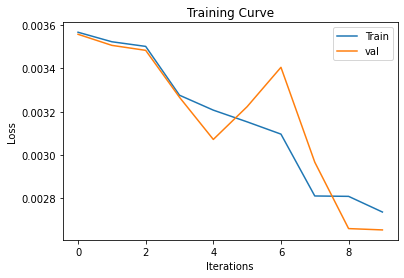

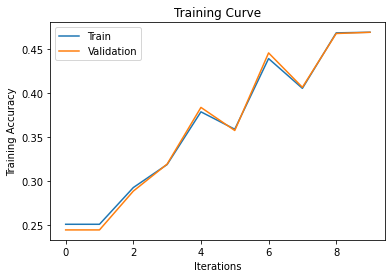

Final Training Accuracy: 0.46926051064126234
Final Validation Accuracy: 0.46921147952075787


In [16]:
use_cuda = True
model1 = CNNalex()

if use_cuda and torch.cuda.is_available():
  model1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2(model1, tData, vData, batch_size = 500, lr= 0.01, num_epochs=10)


Epoch 0
Epoch:  0  Train Accuracy:  0.48671148420355986
Epoch:  0  Validation Accuracy:  0.48537196990805237
Epoch 1
Epoch:  1  Train Accuracy:  0.4928419659340277
Epoch:  1  Validation Accuracy:  0.48927277793257173
Epoch 2
Epoch:  2  Train Accuracy:  0.49928593820753076
Epoch:  2  Validation Accuracy:  0.49233769852326553
Epoch 3
Epoch:  3  Train Accuracy:  0.49381726984569296
Epoch:  3  Validation Accuracy:  0.48704374477570356
Epoch 4
Epoch:  4  Train Accuracy:  0.5074018600438887
Epoch:  4  Validation Accuracy:  0.5023683477291725
Epoch 5
Epoch:  5  Train Accuracy:  0.5074366923264482
Epoch:  5  Validation Accuracy:  0.5004179437169128
Epoch 6
Epoch:  6  Train Accuracy:  0.5171897314431014
Epoch:  6  Validation Accuracy:  0.5126776260796879
Epoch 7
Epoch:  7  Train Accuracy:  0.5023163467902052
Epoch:  7  Validation Accuracy:  0.5037614934522151
Epoch 8
Epoch:  8  Train Accuracy:  0.5176077188338152
Epoch:  8  Validation Accuracy:  0.5146280300919476
Epoch 9
Epoch:  9  Train Accur

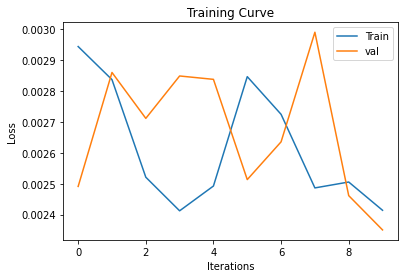

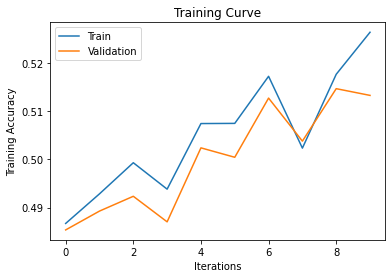

Final Training Accuracy: 0.5263157894736842
Final Validation Accuracy: 0.513234884368905


In [17]:
train2(model1, tData, vData, batch_size = 500, lr= 0.005, num_epochs=10)

Epoch 0
Epoch:  0  Train Accuracy:  0.528719216970288
Epoch:  0  Validation Accuracy:  0.5188074672610755
Epoch 1
Epoch:  1  Train Accuracy:  0.5237730328468424
Epoch:  1  Validation Accuracy:  0.51797157982725
Epoch 2
Epoch:  2  Train Accuracy:  0.5157267755756034
Epoch:  2  Validation Accuracy:  0.5043187517414321
Epoch 3
Epoch:  3  Train Accuracy:  0.5373576230450381
Epoch:  3  Validation Accuracy:  0.5224296461409863
Epoch 4
Epoch:  4  Train Accuracy:  0.5395520568462852
Epoch:  4  Validation Accuracy:  0.5215937587071607
Epoch 5
Epoch:  5  Train Accuracy:  0.544080253579017
Epoch:  5  Validation Accuracy:  0.5338534410699359
Epoch 6
Epoch:  6  Train Accuracy:  0.5466578424884183
Epoch:  6  Validation Accuracy:  0.5358038450821956
Epoch 7
Epoch:  7  Train Accuracy:  0.5504893935699606
Epoch:  7  Validation Accuracy:  0.5355252159375871
Epoch 8
Epoch:  8  Train Accuracy:  0.5497927479187711
Epoch:  8  Validation Accuracy:  0.5413764279743661
Epoch 9
Epoch:  9  Train Accuracy:  0.547

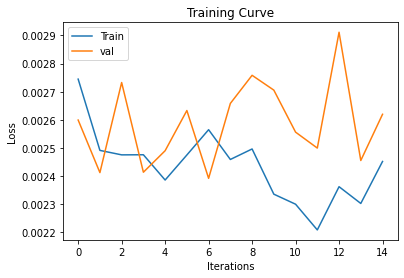

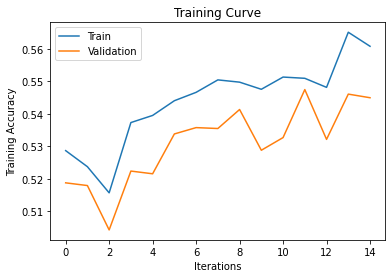

Final Training Accuracy: 0.560834581490125
Final Validation Accuracy: 0.5449986068542769


In [18]:
train2(model1, tData, vData, batch_size = 500, lr= 0.005, num_epochs=15)

Epoch 0
Epoch:  0  Train Accuracy:  0.5656066042007732
Epoch:  0  Validation Accuracy:  0.5424909445528002
Epoch 1
Epoch:  1  Train Accuracy:  0.549270263680379
Epoch:  1  Validation Accuracy:  0.5277235998885483
Epoch 2
Epoch:  2  Train Accuracy:  0.5692988261520777
Epoch:  2  Validation Accuracy:  0.5427695736974087
Epoch 3
Epoch:  3  Train Accuracy:  0.5599637744261381
Epoch:  3  Validation Accuracy:  0.5282808581777654
Epoch 4
Epoch:  4  Train Accuracy:  0.5722595701696332
Epoch:  4  Validation Accuracy:  0.5452772359988854
Epoch 5
Epoch:  5  Train Accuracy:  0.5531714793270402
Epoch:  5  Validation Accuracy:  0.5338534410699359
Epoch 6
Epoch:  6  Train Accuracy:  0.5773799157058762
Epoch:  6  Validation Accuracy:  0.5416550571189747
Epoch 7
Epoch:  7  Train Accuracy:  0.5748371590790344
Epoch:  7  Validation Accuracy:  0.5483421565895793
Epoch 8
Epoch:  8  Train Accuracy:  0.5801316660280749
Epoch:  8  Validation Accuracy:  0.5500139314572304
Epoch 9
Epoch:  9  Train Accuracy:  0.

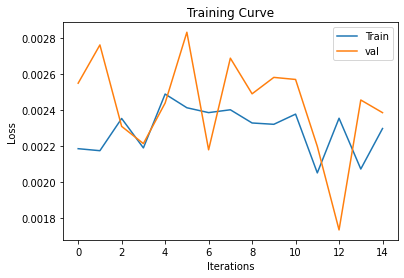

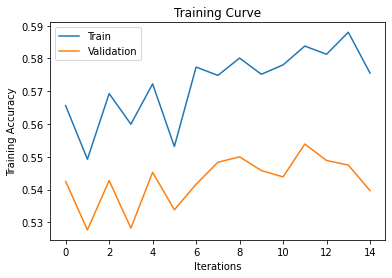

Final Training Accuracy: 0.575533804730224
Final Validation Accuracy: 0.539704653106715


In [19]:
train2(model1, tData, vData, batch_size = 500, lr= 0.005, num_epochs=15)

Epoch 0
Epoch:  0  Train Accuracy:  0.5955623672019228
Epoch:  0  Validation Accuracy:  0.5586514349400947
Epoch 1
Epoch:  1  Train Accuracy:  0.5984186143717998
Epoch:  1  Validation Accuracy:  0.5603232098077459
Epoch 2
Epoch:  2  Train Accuracy:  0.5982444529590024
Epoch:  2  Validation Accuracy:  0.5575369183616606
Epoch 3
Epoch:  3  Train Accuracy:  0.5982792852415619
Epoch:  3  Validation Accuracy:  0.5617163555307885
Epoch 4
Epoch:  4  Train Accuracy:  0.5987321049148351
Epoch:  4  Validation Accuracy:  0.5586514349400947
Epoch 5
Epoch:  5  Train Accuracy:  0.598801769479954
Epoch:  5  Validation Accuracy:  0.5583728057954862
Epoch 6
Epoch:  6  Train Accuracy:  0.5999860670869762
Epoch:  6  Validation Accuracy:  0.5583728057954862
Epoch 7
Epoch:  7  Train Accuracy:  0.6008220418684036
Epoch:  7  Validation Accuracy:  0.5603232098077459
Epoch 8
Epoch:  8  Train Accuracy:  0.6000905639346547
Epoch:  8  Validation Accuracy:  0.5597659515185288
Epoch 9
Epoch:  9  Train Accuracy:  0.

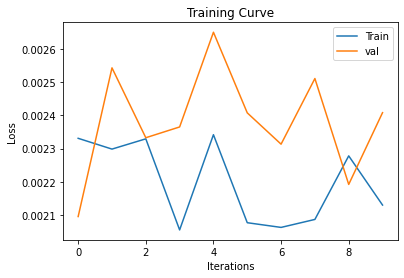

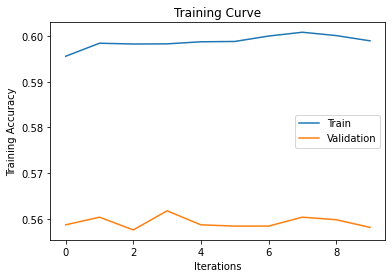

Final Training Accuracy: 0.598941098610192
Final Validation Accuracy: 0.5580941766508777


In [20]:
train2(model1, tData, vData, batch_size = 500, lr= 0.001, num_epochs=10)